<a href="https://colab.research.google.com/github/Yigael-Laloum/Yigael-Laloum/blob/main/%D7%A4%D7%AA%D7%A8%D7%95%D7%A0%D7%95%D7%AA_%D7%99%D7%A4%D7%AA%D7%97_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#חילוץ טיעונים
# Install necessary libraries
!pip install transformers --quiet

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load the DistilBERT model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for classification
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

def extract_claims(text, threshold=0.8):
    """
    Processes input text and extracts claims based on confidence scores.
    Args:
        text (str): The input text.
        threshold (float): The minimum confidence score for a claim.
    Returns:
        list: A list of claims detected in the text.
    """
    # Split the text into sentences
    sentences = text.split(". ")

    # Initialize a list to store detected claims
    claims = []

    for sentence in sentences:
        # Run the classifier on each sentence
        result = classifier(sentence)
        label = result[0]['label']
        score = result[0]['score']

        # Add to claims if classified as 'POSITIVE' with high confidence
        if label == "POSITIVE" and score > threshold:
            claims.append((sentence, score))

    return claims

# Prompt the user for input text
input_text = input("Please enter your text for claim detection:\n")

# Extract claims
detected_claims = extract_claims(input_text)

# Display detected claims
if detected_claims:
    print("\nDetected Claims:")
    for idx, (claim, confidence) in enumerate(detected_claims, start=1):
        print(f"{idx}. Claim: {claim}\n   Confidence: {confidence:.2f}\n")
else:
    print("\nNo claims detected.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

KeyboardInterrupt: Interrupted by user

In [ ]:
#השוואת שירים
!pip install stanza librosa
import stanza
import numpy as np
import librosa

# Initialize Stanza with the Hebrew model
stanza.download('he')
nlp = stanza.Pipeline('he')

# Define a basic mapping from Hebrew vowels to frequency values (in Hertz)
vowel_to_freq = {
    'א': 440.0,  # A4 - Aleph can be a placeholder for many vowels in Hebrew
    'ע': 392.00,  # G4 - Ayin is also often used as a vowel placeholder
    'ה': 329.63,  # E4 - He
    'י': 261.63,  # C4 - Yod
    'ו': 349.23,  # F4 - Vav
}

# Function to split a word into syllables (simple heuristic for Hebrew)
def word_to_syllables(word):
    vowels = "אעהוי"
    syllables = []
    current_syllable = ""
    for char in word:
        current_syllable += char
        if char in vowels:
            syllables.append(current_syllable)
            current_syllable = ""
    if current_syllable:
        syllables.append(current_syllable)
    return syllables

# Function to calculate the tone value of a syllable
def syllable_to_tone(syllable):
    freqs = []
    for char in syllable:
        if char in vowel_to_freq:
            freqs.append(vowel_to_freq[char])
    if freqs:
        return np.mean(freqs)
    else:
        return None

# Function to convert Hz to a musical note
def hz_to_musical_note(hz):
    if hz:
        note = librosa.hz_to_midi(hz)
        return librosa.midi_to_note(int(note))
    return None

# Highlight the end of a line or sentence by raising the pitch
def highlight_pitch(tone, factor=1.5):
    return tone * factor if tone else None

# Main function to process the input text
def process_poetry(poem):
    doc = nlp(poem)  # Use Stanza to process the text
    tones_and_notes = []
    rhymes = []

    for sent in doc.sentences:  # Stanza automatically divides the text into sentences
        line_tones = []
        line_rhyme_syllable = None

        for word in sent.words:  # Stanza tokenizes the sentence into words
            if word.text.isalpha():  # Skip non-alphabetic characters
                syllables = word_to_syllables(word.text)  # Use your custom syllable splitter
                for i, syllable in enumerate(syllables):
                    tone = syllable_to_tone(syllable)
                    note = hz_to_musical_note(tone)
                    line_tones.append((syllable, tone, note))

                # Capture the last syllable of the line for rhyme detection
                line_rhyme_syllable = syllables[-1] if syllables else None

        # Highlight the last syllable in the line
        if line_tones:
            last_syllable, last_tone, _ = line_tones[-1]
            highlighted_tone = highlight_pitch(last_tone)
            highlighted_note = hz_to_musical_note(highlighted_tone)
            line_tones[-1] = (last_syllable, highlighted_tone, highlighted_note)

        # Store rhyme syllables for later analysis
        if line_rhyme_syllable:
            rhymes.append((line_rhyme_syllable, last_tone))  # Storing the syllable and its tone

        tones_and_notes.append(line_tones)

    return tones_and_notes, rhymes

# Function to analyze overall patterns in a poem
def analyze_patterns(tones_and_notes):
    tone_distribution = []
    note_distribution = []

    for line in tones_and_notes:
        for _, tone, note in line:
            if tone:
                tone_distribution.append(tone)
            if note:
                note_distribution.append(note)

    avg_tone = np.mean(tone_distribution) if tone_distribution else None
    tone_variety = len(set(tone_distribution))
    note_variety = len(set(note_distribution))

    return {
        "avg_tone": avg_tone,
        "tone_variety": tone_variety,
        "note_variety": note_variety
    }

# Function to extract rhyme scheme
def extract_rhyme_scheme(rhymes):
    rhyme_scheme = []
    rhyme_map = {}
    next_label = 'A'

    for rhyme, tone in rhymes:
        if rhyme not in rhyme_map:
            rhyme_map[rhyme] = next_label
            next_label = chr(ord(next_label) + 1)  # Move to the next letter

        rhyme_scheme.append((rhyme_map[rhyme], tone))  # Store both the label and the tone

    return rhyme_scheme

# Function to compare the rhyme scheme and tones of two poems
def compare_rhyme_schemes(poem1_rhymes, poem2_rhymes):
    rhyme_scheme1 = extract_rhyme_scheme(poem1_rhymes)
    rhyme_scheme2 = extract_rhyme_scheme(poem2_rhymes)

    rhyme_order_match = [r[0] for r in rhyme_scheme1] == [r[0] for r in rhyme_scheme2]
    rhyme_tone_similarity = len(set([r[1] for r in rhyme_scheme1]) & set([r[1] for r in rhyme_scheme2])) / max(len(rhyme_scheme1), len(rhyme_scheme2))

    return {
        "rhyme_order_match": rhyme_order_match,
        "rhyme_tone_similarity": rhyme_tone_similarity
    }

# Function to compare two poems
def compare_poems(poem1, poem2):
    tones1, rhymes1 = process_poetry(poem1)
    tones2, rhymes2 = process_poetry(poem2)

    patterns1 = analyze_patterns(tones1)
    patterns2 = analyze_patterns(tones2)

    rhyme_comparison = compare_rhyme_schemes(rhymes1, rhymes2)

    comparison = {
        "avg_tone_comparison": (patterns1['avg_tone'], patterns2['avg_tone']),
        "tone_variety_comparison": (patterns1['tone_variety'], patterns2['tone_variety']),
        "note_variety_comparison": (patterns1['note_variety'], patterns2['note_variety']),
        "rhyme_order_match": rhyme_comparison['rhyme_order_match'],
        "rhyme_tone_similarity": rhyme_comparison['rhyme_tone_similarity']
    }

    return comparison

#
poem1 = """
בהרים כבר השמש מלהטת
ובעמק עוד נוצץ הטל,
אנו אוהבים אותך, מולדת,
בשמחה, בשיר ובעמל.

ממורדות הלבנון עד ים המלח
נעבור אותך במחרשות,
אנו עוד ניטע לך ונבנה לך,
אנו ניפה אותך מאד.

נלבישך שלמת בטון ומלט
ונפרוש לך מרבדי גנים,
על אדמת שדותיך הנגאלת
הדגן ירנין פעמונים.

המדבר, אנו דרך בו נחצובה,
הביצות, אנחנו ניבשן,
מה ניתן לך עוד להוד ושובע,
מה עוד לא נתנו וניתן.
"""

poem2 = """
באה המנוחה ליגע
וּמַרְגּוֹעַ לֶעָמֵל.
לַיְלָה חִוֵּר מִשְׂתָּרֵעַ
עַל שְׂדוֹת עֵמֶק יִזְרְעֶאל.
טַל מִלְּמַטָּה וּלְבָנָה מֵעַל,
מִבֵּית אַלְפָא עַד נַהֲלָל.

מַה, מַה לַּיְלָה מִלֵּיל?
דְּמָמָה בְּיִזְרְעֶאל.
נוּמָה עֵמֶק, אֶרֶץ תִּפְאֶרֶת,
אָנוּ לְךָ מִשְׁמֶרֶת.

יָם הַדָּגָן מִתְנוֹעֵעַ,
שִׁיר הָעֵדֶר מְצַלְצֵל,
זוֹהִי אַרְצִי וּשְׂדוֹתֶיהָ,
זֶהוּ עֵמֶק יִזְרְעֶאל.
תְּבֹרַךְ אַרְצִי וְתִתְהַלַּל
מִבֵּית אַלְפָא עַד נַהֲלָל.

אֹפֶל בְּהַר הַגִּלְבּוֹעַ,
סוּס דּוֹהֵר מִצֵּל אֶל צֵל.
קוֹל זְעָקָה עָף גָּבוֹהַּ,
מִשְּׂדוֹת עֵמֶק יִזְרְעֶאל.
מִי יָרָה וּמִי זֶה שָׁם נָפַל
בֵּין בֵּית אַלְפָא וְנַהֲלָל?

"""

# Compare the two poems
comparison = compare_poems(poem1, poem2)

# Display the comparison result
print("\n--- Poem Comparison Results ---")
print(f"Average Tone: Poem 1 = {comparison['avg_tone_comparison'][0]}, Poem 2 = {comparison['avg_tone_comparison'][1]}")
print(f"Tone Variety: Poem 1 = {comparison['tone_variety_comparison'][0]}, Poem 2 = {comparison['tone_variety_comparison'][1]}")
print(f"Note Variety: Poem 1 = {comparison['note_variety_comparison'][0]}, Poem 2 = {comparison['note_variety_comparison'][1]}")
print(f"Rhyme Order Match: {comparison['rhyme_order_match']}")
print(f"Rhyme Tone Similarity: {comparison['rhyme_tone_similarity']:.2f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 31.3 MB/s eta 0:00:00


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: he (Hebrew) ...


INFO:stanza:Downloaded file to /root/stanza_resources/he/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: he (Hebrew):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |
| ner       | iahlt_charlm      |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions


--- Poem Comparison Results ---
Average Tone: Poem 1 = 347.6964948453608, Poem 2 = 409.2739285714287
Tone Variety: Poem 1 = 5, Poem 2 = 6
Note Variety: Poem 1 = 5, Poem 2 = 6
Rhyme Order Match: False
Rhyme Tone Similarity: 0.12


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00

✘ No compatible package found for 'en_core_web_sm!' (spaCy v3.7.5)


Character: Lolita
Names: lolita
Adjectives: 
Adverbs: 
Average Sentiment: 0.10
Sentiment Arc: -0.34 -> 0.75

Character: Lo-Lee-Ta
Names: lo-lee-ta
Adjectives: 
Adverbs: 
Average Sentiment: No sentiment data
Sentiment Arc: No significant sentiment data

Character: Lee
Names: lee
Adjectives: 
Adverbs: 
Average Sentiment: 0.00
Sentiment Arc: No significant sentiment data

Character: Lo
Names: lo
Adjectives: plain
Adverbs: 
Average Sentiment: 0.00
Sentiment Arc: No significant sentiment data

Character: Danube
Names: danube
Adjectives: 
Adverbs: 
Average Sentiment: 0.44
Sentiment Arc: 0.44

Character: Jerome Dunn
Names: jerome dunn
Adjectives: 
Adverbs: 
Average Sentiment: No sentiment data
Sentiment Arc: No significant sentiment data

Character: Sybil
Names: sybil
Adjectives: 
Adverbs: 
Average Sentiment: -0.26
Sentiment Arc: -0.53

Characte

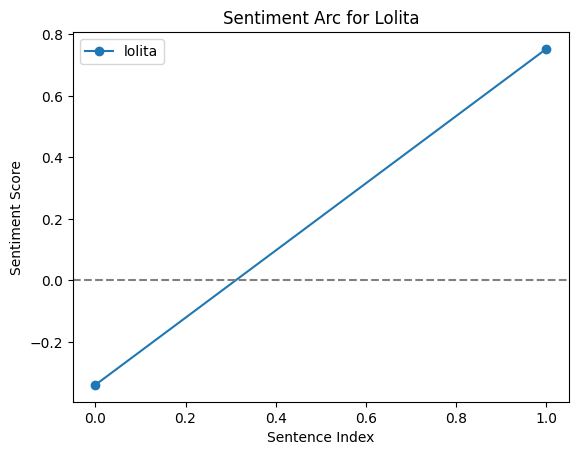

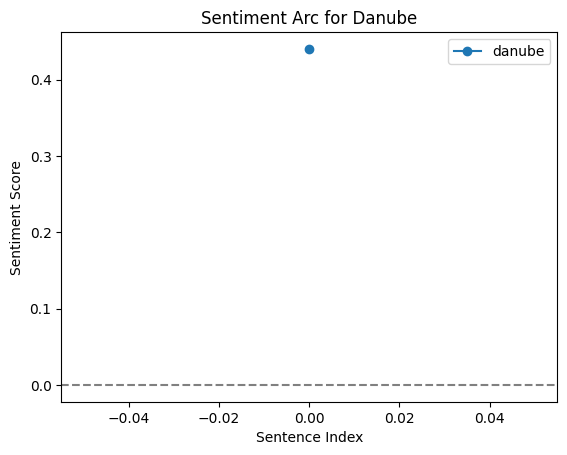

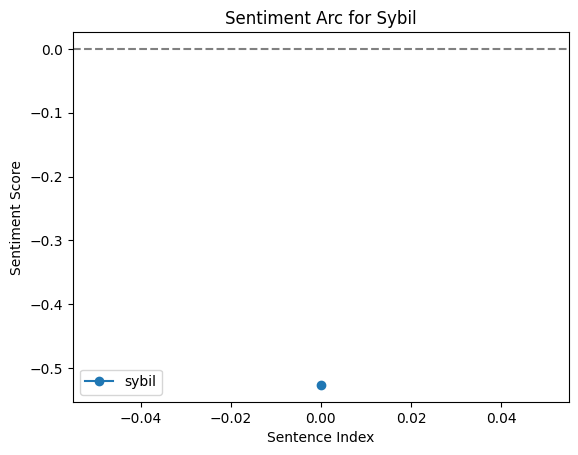

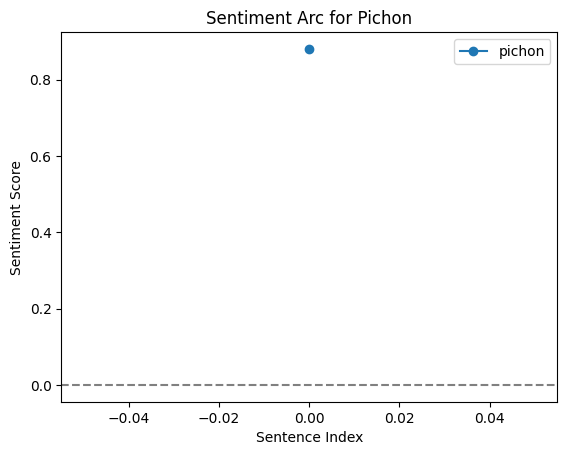

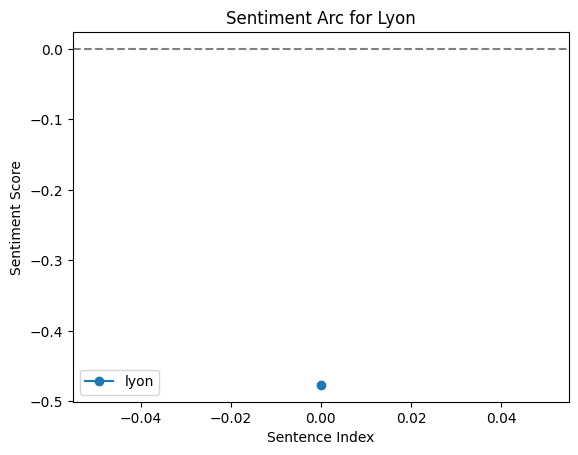

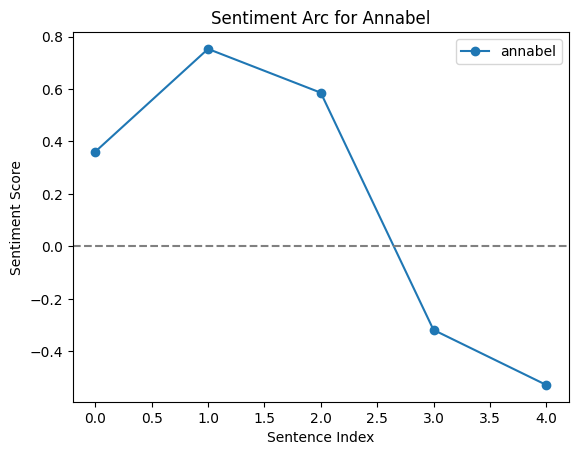

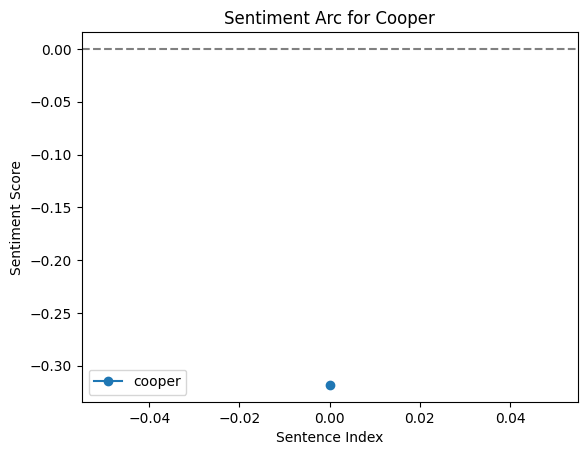

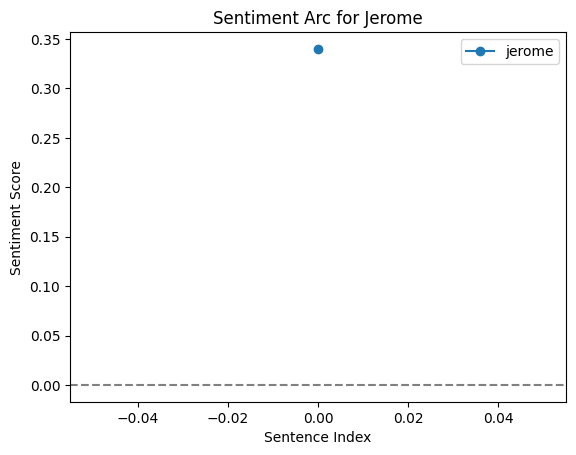

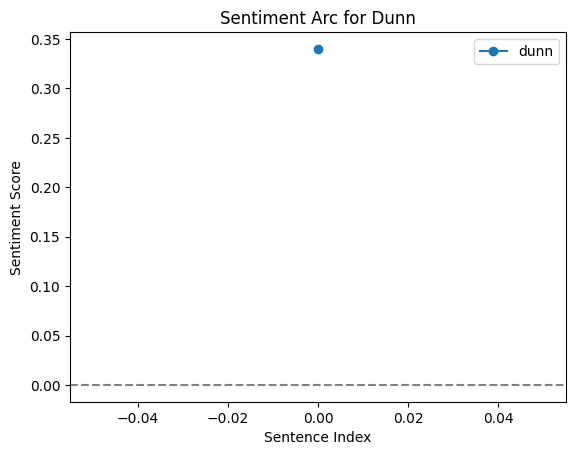

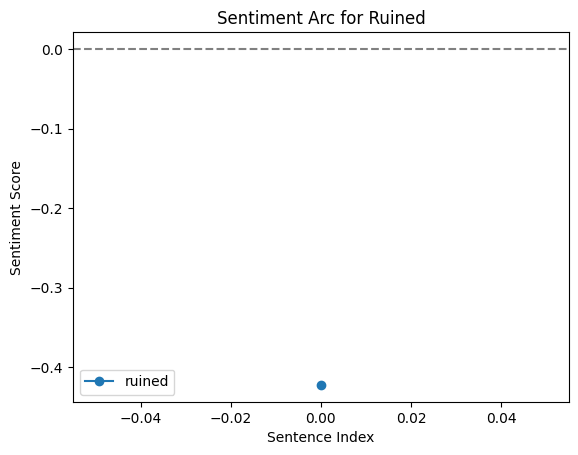

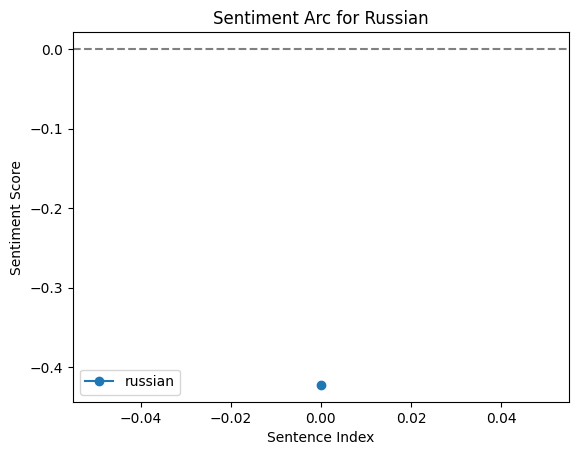

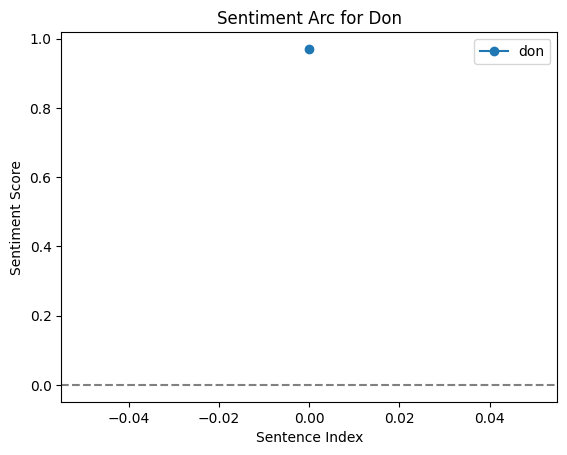

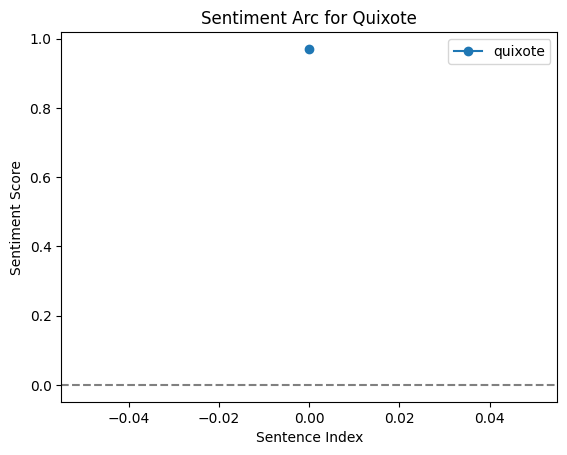

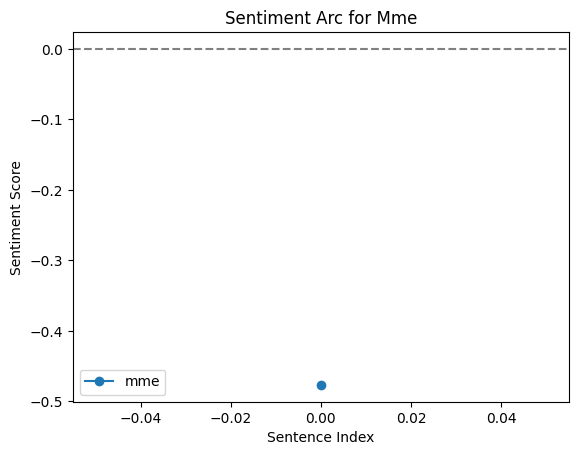

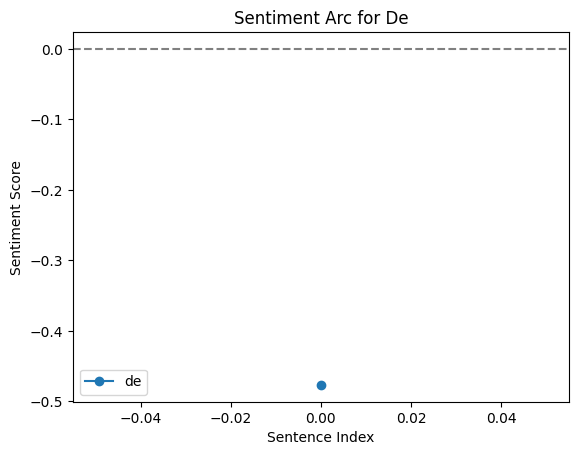

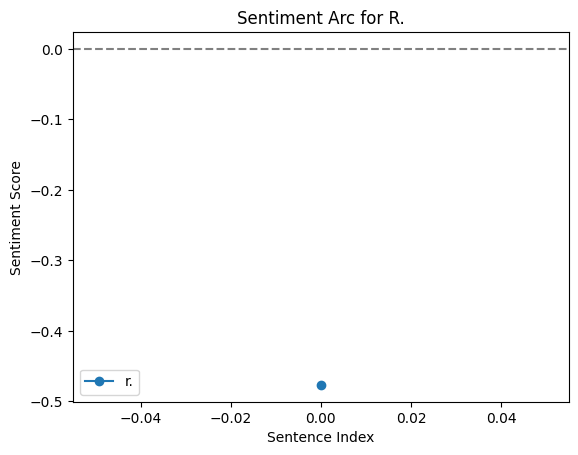

In [ ]:
#קבוצה  סנטימנט ודמויות
!pip install vaderSentiment spacy
!python -m spacy download en_core_web_sm! # Import necessary libraries
import spacy
import re
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Ensure inline display of plots
%matplotlib inline

# Load the small English model for SpaCy
nlp = spacy.load('en_core_web_sm')

# Initialize the VADER sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

def find_adj_adv_sentiment_for_characters(text):
    """
    This function extracts characters, their adjectives (ADJ), adverbs (ADV),
    and sentiment from each sentence. It also computes average sentiment and
    tracks sentiment evolution (arc) for each character.
    """
    # Process the text using SpaCy
    doc = nlp(text)

    # Dictionary to store full names and their variants, adjectives, adverbs, and sentiment
    character_dict = defaultdict(lambda: {
        "names": [],
        "adjectives": [],
        "adverbs": [],
        "sentiment_scores": [],
        "sentiment_arc": []
    })

    # List to store all characters mentioned
    all_characters = []

    # First, we find all "PERSON" entities
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            # Add character to the list of all characters
            all_characters.append(ent.text)

    # Clean and standardize names (lowercase, remove extra spaces)
    standardized_characters = [re.sub(r'\s+', ' ', char.lower().strip()) for char in all_characters]

    # Build character dictionary with full names as keys
    for char in standardized_characters:
        parts = char.split()
        if len(parts) == 1:  # Single name (either first or last name)
            for full_name in character_dict:
                if parts[0] in full_name.split():
                    character_dict[full_name]["names"].append(char)
                    break
            else:
                # If it's not found, we add it as a new full name
                character_dict[char]["names"].append(char)
        else:  # Full name
            character_dict[char]["names"].append(char)

    # Split text into sentences for sentiment analysis
    sentences = list(doc.sents)

    # Loop through each sentence to perform sentiment analysis and track character mentions
    for sentence in sentences:
        sentence_text = sentence.text
        sentiment_score = sentiment_analyzer.polarity_scores(sentence_text)['compound']  # Overall sentiment

        # Process each token in the sentence to check for character mentions
        for token in sentence:
            if token.ent_type_ == "PERSON":
                char_name = token.text.lower()

                # Record sentiment score for the character
                character_dict[char_name]["sentiment_scores"].append(sentiment_score)
                character_dict[char_name]["sentiment_arc"].append(sentiment_score)

                # Search for adjectives (ADJ) and adverbs (ADV) in the neighborhood
                for child in token.children:
                    if child.pos_ == "ADJ":
                        character_dict[char_name]["adjectives"].append(child.text)
                    if child.pos_ == "ADV":
                        character_dict[char_name]["adverbs"].append(child.text)

    # Calculate the average sentiment for each character
    for full_name, details in character_dict.items():
        if details["sentiment_scores"]:
            avg_sentiment = sum(details["sentiment_scores"]) / len(details["sentiment_scores"])
            character_dict[full_name]["average_sentiment"] = avg_sentiment
        else:
            character_dict[full_name]["average_sentiment"] = None  # No sentiment for this character

    # Combine character references and filter duplicates
    final_characters = {full_name: {
                            "names": set(details["names"]),
                            "adjectives": set(details["adjectives"]),
                            "adverbs": set(details["adverbs"]),
                            "average_sentiment": details["average_sentiment"],
                            "sentiment_arc": details["sentiment_arc"]
                        }
                        for full_name, details in character_dict.items()}

    return final_characters

def plot_sentiment_arc(characters):
    """
    Plot the sentiment arc for each character based on their sentiment scores over time,
    excluding neutral results (near 0). Only plot if there are valid sentiment scores.
    """
    for character, details in characters.items():
        # Filter out neutral sentiment (sentiment near 0)
        sentiment_arc = [score for score in details["sentiment_arc"] if abs(score) > 0.05]

        if sentiment_arc:
            plt.figure()
            plt.plot(sentiment_arc, marker='o', label=character)
            plt.title(f'Sentiment Arc for {character.title()}')
            plt.xlabel('Sentence Index')
            plt.ylabel('Sentiment Score')
            plt.axhline(0, color='gray', linestyle='--')
            plt.legend()
            plt.show()

def display_character_details(characters):
    """
    Display the character details in list form, each item on a new line.
    Handle cases where the average sentiment is None.
    """
    for character, details in characters.items():
        print(f"\nCharacter: {character.title()}")
        print(f"Names: {', '.join(details['names'])}")
        print(f"Adjectives: {', '.join(details['adjectives'])}")
        print(f"Adverbs: {', '.join(details['adverbs'])}")

        if details['average_sentiment'] is not None:
            print(f"Average Sentiment: {details['average_sentiment']:.2f}")
        else:
            print(f"Average Sentiment: No sentiment data")

        # Only display sentiment arc if there are non-neutral sentiment values
        sentiment_arc = [f"{score:.2f}" for score in details['sentiment_arc'] if abs(score) > 0.05]
        if sentiment_arc:
            print("Sentiment Arc:", " -> ".join(sentiment_arc))
        else:
            print("Sentiment Arc: No significant sentiment data")

# Example usage
sample_text = """


Lolita, light of my life, fire of my loins. My sin, my soul. Lo-lee-ta: the tip of the tongue taking a trip of three steps down the palate to tap, at three, on the teeth. Lo. Lee. Ta.

She was Lo, plain Lo, in the morning, standing four feet ten in one sock. She was Lola in slacks. She was Dolly at school. She was Dolores on the dotted line. But in my arms she was always Lolita.

Did she have a precursor? She did, indeed she did. In point of fact, there might have been no Lolita at all had I not loved, one summer, a certain initial girl-child. In a princedom by the sea. Oh when? About as many years before Lolita was born as my age was that summer. You can always count on a murderer for a fancy prose style.

Ladies and gentlemen of the jury, exhibit number one is what the seraphs, the misinformed, simple, noble-winged seraphs, envied. Look at this tangle of thorns.



I was born in 1910, in Paris. My father was a gentle, easy-going person, a salad of racial genes: a Swiss citizen, of mixed French and Austrian descent, with a dash of the Danube in his veins. I am going to pass around in a minute some lovely, glossy-blue picture-postcards. He owned a luxurious hotel on the Riviera. His father and two grandfathers had sold wine, jewels and silk, respectively. At thirty he married an English girl, daughter of Jerome Dunn, the alpinist, and granddaughter of two Dorset parsons, experts in obscure subjectspaleopedology and Aeolian harps, respectively. My very photogenic mother died in a freak accident (picnic, lightning) when I was three, and, save for a pocket of warmth in the darkest past, nothing of her subsists within the hollows and dells of memory, over which, if you can still stand my style (I am writing under observation), the sun of my infancy had set: surely, you all know those redolent remnants of day suspended, with the midges, about some hedge in bloom or suddenly entered and traversed by the rambler, at the bottom of a hill, in the summer dusk; a furry warmth, golden midges.

My mother’s elder sister, Sybil, whom a cousin of my father’s had married and then neglected, served in my immediate family as a kind of unpaid governess and housekeeper. Somebody told me later that she had been in love with my father, and that he had lightheartedly taken advantage of it one rainy day and forgotten it by the time the weather cleared. I was extremely fond of her, despite the rigiditythe fatal rigidityof some of her rules. Perhaps she wanted to make of me, in the fullness of time, a better widower than my father. Aunt Sybil had pink-rimmed azure eyes and a waxen complexion. She wrote poetry. She was poetically superstitious. She said she knew she would die soon after my sixteenth birthday, and did. Her husband, a great traveler in perfumes, spent most of his time in America, where eventually he founded a firm and acquired a bit of real estate.

I grew, a happy, healthy child in a bright would of illustrated books, clean sand, orange trees, friendly dogs, sea vistas and smiling faces. Around me the splendid Hotel Mirana revolved as a kind of private universe, a whitewashed cosmos within the blue greater one that blazed outside. From the aproned pot-scrubber to the flanneled potentate, everybody liked me, everybody petted me. Elderly American ladies leaning on their canes listed towards me like towers of Pisa. Ruined Russian princesses who could not pay my father, bought me expensive bonbons. He, mon cher petit papa , took me out boating and biking, taught me to swim and dive and water-ski, read to me Don Quixote  and Les Miserables , and I adored and respected him and felt glad for him whenever I overheard the servants discuss his various lady-friends, beautiful and kind beings who made much of me and cooed and shed precious tears over my cheerful motherlessness.

I attended an English day school a few miles from home, and there I played rackets and fives, and got excellent marks, and was on perfect terms with schoolmates and teachers alike. The only definite sexual events that I can remember as having occurred before my thirteenth birthday (that is, before I first saw my little Annabel) were: a solemn, decorous and purely theoretical talk about pubertal surprises in the rose garden of the school with an American kid, the son of a then celebrated motion-picture actress whom he seldom saw in the three-dimensional world; and some interesting reactions on the part of my organism to certain photographs, pearl and umbra, with infinitely soft partings, in Pichon’s sumptuous Le Beaute Humaine  that that I had filched from under a mountain of marble-bound Graphics  in the hotel library. Later, in his delightful debonair manner, my father gave me all the information he thought I needed about sex; this was just before sending me, in the autumn of 1923, to a lyce  in Lyon (where we were to spend three winters); but alas, in the summer of that year, he was touring Italy with Mme de R. and her daughter, and I had nobody to complain to, nobody to consult.



Annabel was, like the writer, of mixed parentage: half-English, half-Dutch, in her case. I remember her features far less distinctly today than I did a few years ago, before I knew Lolita. There are two kinds of visual memory: one when you skillfully recreate an image in the laboratory of your mind, with your eyes open (and then I see Annabel in such general terms as: “honey-colored skin,” “think arms,” “brown bobbed hair,” “long lashes,” “big bright mouth”); and the other when you instantly evoke, with shut eyes, on the dark inner side of your eyelids, the objective, absolutely optical replica of a beloved face, a little ghost in natural colors (and this is how I see Lolita).

Let me therefore primly limit myself, in describing Annabel, to saying she was a lovely child a few months my junior. Her parents were old friends of my aunt’s, and as stuffy as she. They had rented a villa not far from Hotel Mirana. Bald brown Mr. Leigh and fat, powdered Mrs. Leigh (born Vanessa van Ness). How I loathed them! At first, Annabel and I talked of peripheral affairs. She kept lifting handfuls of fine sand and letting it pour through her fingers. Our brains were turned the way those of intelligent European preadolescents were in our day and set, and I doubt if much individual genius should be assigned to our interest in the plurality of inhabited worlds, competitive tennis, infinity, solipsism and so on. The softness and fragility of baby animals caused us the same intense pain. She wanted to be a nurse in some famished Asiatic country; I wanted to be a famous spy.

All at once we were madly, clumsily, shamelessly, agonizingly in love with each other; hopelessly, I should add, because that frenzy of mutual possession might have been assuaged only by our actually imbibing and assimilating every particle of each other’s soul and flesh; but there we were, unable even to mate as slum children would have so easily found an opportunity to do. After one wild attempt we made to meet at night in her garden (of which more later), the only privacy we were allowed was to be out of earshot but not out of sight on the populous part of the plage . There, on the soft sand, a few feet away from our elders, we would sprawl all morning, in a petrified paroxysm of desire, and take advantage of every blessed quirk in space and time to touch each other: her hand, half-hidden in the sand, would creep toward me, its slender brown fingers sleepwalking nearer and nearer; then, her opalescent knee would start on a long cautious journey; sometimes a chance rampart built by younger children granted us sufficient concealment to graze each other’s salty lips; these incomplete contacts drove our healthy and inexperienced young bodies to such a state of exasperation that not even the cold blue water, under which we still clawed at each other, could bring relief.

Among some treasures I lost during the wanderings of my adult years, there was a snapshot taken by my aunt which showed Annabel, her parents and the staid, elderly, lame gentleman, a Dr. Cooper, who that same summer courted my aunt, grouped around a table in a sidewalk cafe. Annabel did not come out well, caught as she was in the act of bending over her chocolat glace , and her thin bare shoulders and the parting in her hair were about all that could be identified (as I remember that picture) amid the sunny blur into which her lost loveliness graded; but I, sitting somewhat apart from the rest, came out with a kind of dramatic conspicuousness: a moody, beetle-browed boy in a dark sport shirt and well-tailored white shorts, his legs crossed, sitting in profile, looking away. That photograph was taken on the last day of our fatal summer and just a few minutes before we made our second and final attempt to thwart fate. Under the flimsiest of pretexts (this was our very last chance, and nothing really mattered) we escaped from the cafe to the beach, and found a desolate stretch of sand, and there, in the violet shadow of some red rocks forming a kind of cave, had a brief session of avid caresses, with somebody’s lost pair of sunglasses for only witness. I was on my knees, and on the point of possessing my darling, when two bearded bathers, the old man of the sea and his brother, came out of the sea with exclamations of ribald encouragement, and four months later she died of typhus in Corfu

Источник: http://nabokov-lit.ru/nabokov/proza/lolita/1-chapters-1-8.htm

"""

characters = find_adj_adv_sentiment_for_characters(sample_text)

# Display character details in list form
display_character_details(characters)

# Plot sentiment arc for characters with non-neutral sentiment
plot_sentiment_arc(characters)

In [ ]:
!pip install spacy groq
!python -m spacy download en_core_web_sm
import spacy
from groq import Groq
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# כאן צריך להביא מפתח מhttps://console.groq.com/playground
os.environ['GROQ_API_KEY'] = ''

def extract_info(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    actions = [token.lemma_ for token in doc if token.pos_ == "VERB"]
    times = [ent.text for ent in doc.ents if ent.label_ in ["TIME", "DATE"]]
    locations = [ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]

    return people, actions, times, locations

def analyze_relationships(text, people, locations, times):
    client = Groq()

    system_message = """Role: excellent text analysis
Function: Read carefully the text and the person list, location list, and time list.
Create a JSON dictionary that includes:
1. All the people mentioned and their connections to other people: K (kin), F (friends), E (enemies), R (romantic). If there's no connection, don't include it.
2. Any relationships between people and places mentioned.
3. Any relationships between people and times mentioned.
4. All events mentioned in the text, including who was involved, where it happened (if mentioned), and when it happened (if mentioned).
Ensure the output is a valid JSON object."""

    user_message = f"""Text: {text}
People: {people}
Locations: {locations}
Times: {times}

Please analyze the relationships between the people, places, and times mentioned, as well as all events, and provide the result in JSON format."""

    completion = client.chat.completions.create(
        model="llama3-groq-70b-8192-tool-use-preview",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ],
        temperature=0.5,
        max_tokens=1024,
        top_p=0.65,
        stream=True,
        stop=None
    )

    result = ""
    for chunk in completion:
        content = chunk.choices[0].delta.content or ""
        result += content
        print(content, end="")

    return json.loads(result)

def create_comprehensive_graph(relationships):
    G = nx.Graph()

    # Add nodes for people and their relationships
    for person, relations in relationships['people'].items():
        G.add_node(person, node_type='person')
        for relation_type, related_people in relations.items():
            for related_person in related_people:
                G.add_edge(person, related_person, relation_type=relation_type)

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20), gridspec_kw={'height_ratios': [2, 1]})

    # Draw people network
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color='lightblue', node_size=3000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, ax=ax1)

    # Draw edges with different colors for different relationship types
    edge_colors = {'K': 'green', 'F': 'blue', 'E': 'red', 'R': 'purple'}
    for (u, v, data) in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], ax=ax1,
                               edge_color=edge_colors.get(data['relation_type'], 'gray'))

    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'relation_type')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax1)

    ax1.set_title("People Relationships")
    ax1.axis('off')

    # Draw events timeline
    events = relationships['events']
    ax2.set_ylim(0, len(events))
    ax2.set_xlim(0, 10)
    ax2.set_title("Events Timeline")
    ax2.set_yticks(range(len(events)))
    ax2.set_yticklabels([f"Event {i+1}" for i in range(len(events))])
    ax2.set_xlabel("Time")

    for i, event in enumerate(events):
        rect = Rectangle((0, i), 10, 0.8, fill=False)
        ax2.add_patch(rect)

        # Create event text robustly
        event_parts = []
        for key in ['who', 'what', 'where', 'when']:
            if key in event and event[key]:
                event_parts.append(str(event[key]))
        event_text = " ".join(event_parts)

        ax2.text(0.1, i+0.4, event_text, va='center')

    plt.tight_layout()
    plt.show()
# Example usage
text = """Noah was six hundred years old when the floodwaters came on the earth. 7 And Noah and his sons and his wife and his sons’ wives entered the ark to escape the waters of the flood. 8 Pairs of clean and unclean animals, of birds and of all creatures that move along the ground, 9 male and female, came to Noah and entered the ark, as God had commanded Noah. 10 And after the seven days the floodwaters came on the earth.

11 In the six hundredth year of Noah’s life, on the seventeenth day of the second month—on that day all the springs of the great deep burst forth, and the floodgates of the heavens were opened. 12 And rain fell on the earth forty days and forty nights.

13 On that very day Noah and his sons, Shem, Ham and Japheth, together with his wife and the wives of his three sons, entered the ark. 14 They had with them every wild animal according to its kind, all livestock according to their kinds, every creature that moves along the ground according to its kind and every bird according to its kind, everything with wings. 15 Pairs of all creatures that have the breath of life in them came to Noah and entered the ark. 16 The animals going in were male and female of every living thing, as God had commanded Noah. Then the Lord shut him in.

"""

people, actions, times, locations = extract_info(text)

print("\nExtracted Information:")
print("People:", people)
print("Actions:", actions)
print("Times:", times)
print("Locations:", locations)

print("\nAnalyzing relationships and events:")
relationships = analyze_relationships(text, people, locations, times)

print("\nRelationship and Event Analysis Result:")
print(json.dumps(relationships, indent=2))

print("\nCreating Comprehensive Network Graph:")
create_comprehensive_graph(relationships)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data dictionaries
data_1 = {
    "2010": {"percentage": "13.7%", "amount": 60},
    "2011": {"percentage": "13.7%", "amount": 55},
    "2012": {"percentage": "12.2%", "amount": 54},
    "2013": {"percentage": "10.8%", "amount": 47},
    "2014": {"percentage": "12.1%", "amount": 48},
    "2015": {"percentage": "9.7%", "amount": 47},
}

data_2 = {
    "2010": {"percentage of household spending on books": "13.7%", "amount in shekels": 60},
    "2011": {"percentage of household spending on books": "13.7%", "amount in shekels": 55},
    "2012": {"percentage of household spending on books": "12.2%", "amount in shekels": 54},
    "2013": {"percentage of household spending on books": "10.8%", "amount in shekels": 47},
    "2014": {"percentage of household spending on books": "12.1%", "amount in shekels": 48},
    "2015": {"percentage of household spending on books": "9.7%", "amount in shekels": 47},
}

data_3 = {
    "2011": {"percentage of book purchases": "7.6%", "number of books purchased (in thousands)": 169.1},
    "2010": {"percentage of book purchases": "8.4%", "number of books purchased (in thousands)": 182.5},
    "2009": {"percentage of book purchases": "7.8%", "number of books purchased (in thousands)": 165.1},
    "2008": {"percentage of book purchases": "8.7%", "number of books purchased (in thousands)": 183.8},
    "2007": {"percentage of book purchases": "9.5%", "number of books purchased (in thousands)": 196.3},
}

data_4 = {
    "2006": {"total expenditure on culture and sports (in millions)": 36454, "expenditure on books (in millions)": 2194.2},
    "2007": {"total expenditure on culture and sports (in millions)": 39441.2, "expenditure on books (in millions)": 2311.2},
    "2008": {"total expenditure on culture and sports (in millions)": 39513.6, "expenditure on books (in millions)": 2338.6},
    "2009": {"total expenditure on culture and sports (in millions)": 40628.3, "expenditure on books (in millions)": 2573.1},
    "2010": {"total expenditure on culture and sports (in millions)": 43227.1, "expenditure on books (in millions)": 2723.8},
}

data_5 = {
    "2003": {"titles": 7128, "books": 6436},
    "2004": {"titles": 8201, "books": 6436},
    "2005": {"titles": 8405, "books": 6840},
    "2006": {"titles": 8680, "books": 6866},
    "2007": {"titles": 7860, "books": 5850},
}

# Helper function to create bar plots
def plot_data(data, title, ylabel):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.apply(pd.to_numeric, errors='coerce')  # Ensure values are numeric
    df.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting data
plot_data(data_1, "Data 1: Percentage and Amount Over Years", "Amount")
plot_data(data_2, "Data 2: Household Spending on Books Over Years", "Amount in Shekels")
plot_data(data_3, "Data 3: Book Purchases and Number Over Years", "Number of Books Purchased (in thousands)")
plot_data(data_4, "Data 4: Expenditure on Culture and Books Over Years", "Expenditure (in millions)")
plot_data(data_5, "Data 5: Titles and Books Over Years", "Number of Titles/Books")